<a href="https://colab.research.google.com/github/KimGriezmann/DeepLearning_BeTheLegend/blob/master/MLP_model/MLP_4season_acc_74.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2018-2019-2020-2021시즌 데이터를 사용한 MLP model**
### Number of data = *31170*
최소 3타석 이상의 기록들만 사용\
※문제는 3타석 이상의 기록에서는 0 / 1의 분포가 70%
### Number of feature = *12*

1. avg (타율)
2. slg (장타율)
3. ops (출루율 + 장타율)
4. home/away_avg_y (홈/원정 별 타율)
5. vs_ab (상대 팀 누적 타수)
6. vs_hit (상대 팀 누적 안타)
7. vs_avg (상대 팀 타율)
8. recent_5days_avg (최근 5일 타율)
9. recent_5games_avg (최근 5경기 타율)
10. recent_10games_avg (최근 10경기 타율)
11. success_10days (최근 10일 성공률)
12. success_10games (최근 10경기 성공률)

acc = 0.7422



In [1]:
import numpy as np
import pandas as pd
import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_2021 = pd.read_csv('/content/drive/MyDrive/bethelegend/data_2021.csv', encoding='euc-kr')
batter_data_2021 = pd.read_csv('/content/drive/MyDrive/bethelegend/batter_data_2021.csv', encoding='euc-kr')

data_2020 = pd.read_csv('/content/drive/MyDrive/bethelegend/data_2020.csv', encoding='euc-kr')
batter_data_2020 = pd.read_csv('/content/drive/MyDrive/bethelegend/batter_data_2020.csv', encoding='euc-kr')

data_2019 = pd.read_csv('/content/drive/MyDrive/bethelegend/data_2019.csv', encoding='euc-kr')
batter_data_2019 = pd.read_csv('/content/drive/MyDrive/bethelegend/batter_data_2019.csv', encoding='euc-kr')

data_2018 = pd.read_csv('/content/drive/MyDrive/bethelegend/data_2018.csv', encoding='euc-kr')
batter_data_2018 = pd.read_csv('/content/drive/MyDrive/bethelegend/batter_data_2018.csv', encoding='euc-kr')

### **날짜 형식 변경**

In [5]:
import pandas as pd
import numpy as numpy

# 날짜 데이터 값, 형식 변경
# 현재 : object 형식으로 "2018-04-04" 값으로 존재 (의미 : 4월 4일)
# 변경 : int 형식으로 20180404 으로 변경 (의미 : 2018년 4월 4일)

def day_to_int(data):
  data['day'] = pd.to_numeric(data['day'].str.replace("-",""))
  return data

In [6]:
data_2021 = day_to_int(data_2021)
data_2020 = day_to_int(data_2020)
data_2019 = day_to_int(data_2019)
data_2018 = day_to_int(data_2018)

### **더블헤더 처리**

In [7]:
def double_header(data):

  temp = np.zeros(len(data))

  # day, name이 같은 값이 있다는 것은 더블헤더 경기가 있다는것
  # keep=False 옵션은 중복 값에 해당하는 튜플들을 모두 True로 리턴, 그 외 옵션 : 'first', 'last' 의 경우 둘 중 하나만 True
  dup = data.loc[:,['day','name']].duplicated(keep=False) 

  for i in range(len(data)):
    if dup[i]==False:
      temp[i]=0
    elif dup[i]==True:
      temp[i]=1

  # 중복의 첫번째 행은 더블헤더 1차전
  # 중복인 두번째 행이 더블헤더 2차전이다.
  for i in range(1,len(temp)):
    if temp[i]==1 and temp[i-1]==1:
      temp[i]=2

  data['double']=temp

  return data

In [8]:
data_2021 = double_header(data_2021)
data_2020 = double_header(data_2020)
data_2019 = double_header(data_2019)
data_2018 = double_header(data_2018)

In [9]:
ex_2021_data = data_2021.loc[:, ['name', 'day', 'double', 'vs', 'ab', 'hit']]
ex_2020_data = data_2020.loc[:, ['name', 'day', 'double', 'vs', 'ab', 'hit']]
ex_2019_data = data_2019.loc[:, ['name', 'day', 'double', 'vs', 'ab', 'hit']]
ex_2018_data = data_2018.loc[:, ['name', 'day', 'double', 'vs', 'ab', 'hit']]

In [ ]:
ex_2021_data

,name,day,double,vs,ab,hit
0,강백호,20210404,0.0,한화,3,2
1,강백호,20210406,0.0,LG,4,0
2,강백호,20210407,0.0,LG,4,3
3,강백호,20210408,0.0,LG,4,2
4,강백호,20210409,0.0,@삼성,5,3
...,...,...,...,...,...,...
5815,김민하,20210623,0.0,@삼성,3,1
5816,김민하,20210624,0.0,@삼성,4,0
5817,김민하,20210626,0.0,KT,1,0
5818,김민하,20210709,0.0,@SSG,4,1


In [ ]:
ex_2020_data

,name,day,double,vs,ab,hit
0,나성범,20200505,0.0,@삼성,3,2
1,나성범,20200506,0.0,@삼성,4,0
2,나성범,20200507,0.0,@삼성,3,0
3,나성범,20200508,0.0,LG,3,0
4,나성범,20200510,0.0,LG,5,3
...,...,...,...,...,...,...
10983,하주석,20200920,0.0,@KIA,4,2
10984,하주석,20200922,0.0,두산,3,1
10985,하주석,20200923,0.0,두산,4,2
10986,하주석,20200924,0.0,롯데,5,1


In [ ]:
ex_2019_data

,name,day,double,vs,ab,hit
0,박민우,20190413,0.0,롯데,4,2
1,박민우,20190414,0.0,롯데,4,2
2,박민우,20190416,0.0,LG,5,2
3,박민우,20190417,0.0,LG,5,0
4,박민우,20190418,0.0,LG,4,2
...,...,...,...,...,...,...
10989,정근우,20190925,0.0,@NC,3,2
10990,정근우,20190926,0.0,@NC,2,0
10991,정근우,20190928,0.0,@두산,5,3
10992,정근우,20190929,0.0,SK,3,0


In [ ]:
ex_2018_data

,name,day,double,vs,ab,hit
0,나성범,20180324,0.0,LG,4,0
1,나성범,20180325,0.0,LG,3,1
2,나성범,20180327,0.0,한화,4,2
3,나성범,20180328,0.0,한화,4,0
4,나성범,20180329,0.0,한화,4,2
...,...,...,...,...,...,...
11311,강경학,20181006,0.0,@롯데,1,0
11312,강경학,20181009,0.0,@KT,3,1
11313,강경학,20181019,0.0,넥센,0,0
11314,강경학,20181020,0.0,넥센,1,0


### **vs에서 @ 유무에 따라 home / away 구분하기**

In [10]:
def make_vs(data):
  data['vs_team'] = [s[1:] if s[0] == '@' else s for s in data['vs']] 

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['double'] = data['double']
  result_Dataframe['vs'] = data['vs']
  result_Dataframe['vs_team'] = data['vs_team']
  result_Dataframe['ab'] = data['ab']
  result_Dataframe['hit'] = data['hit']
  result_Dataframe

  return result_Dataframe

In [11]:
ex_2021_data_2 = make_vs(ex_2021_data)
ex_2020_data_2 = make_vs(ex_2020_data)
ex_2019_data_2 = make_vs(ex_2019_data)
ex_2018_data_2 = make_vs(ex_2018_data)

### **해당 경기의 안타 성공 결과(result) 도출**

In [12]:
def make_result(data):
  data['result'] = [0 if s == 0 else 1 for s in data['hit']] 

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['double'] = data['double']
  result_Dataframe['vs'] = data['vs']
  result_Dataframe['vs_team'] = data['vs_team']
  result_Dataframe['ab'] = data['ab']
  result_Dataframe['hit'] = data['hit']
  result_Dataframe['result'] = data['result']
  result_Dataframe

  return result_Dataframe

In [13]:
ex_2021_data_3 = make_result(ex_2021_data_2)
ex_2020_data_3 = make_result(ex_2020_data_2)
ex_2019_data_3 = make_result(ex_2019_data_2)
ex_2018_data_3 = make_result(ex_2018_data_2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


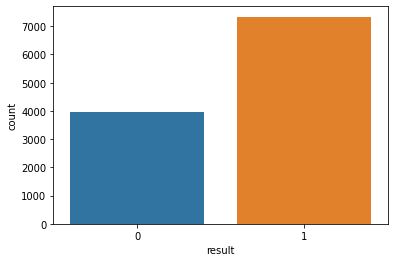

In [ ]:
sns.countplot(ex_2018_data_3['result'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


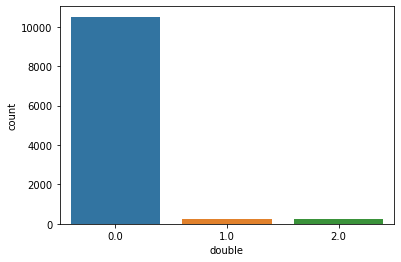

In [ ]:
sns.countplot(ex_2020_data_3['double'])
plt.show()

### **home/away 구분하는 열 추가**

In [14]:
def make_home_away(data):
  data['home/away'] = ['away' if s[0] == '@' else 'home' for s in data['vs']]

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['double'] = data['double']
  result_Dataframe['vs'] = data['vs']
  result_Dataframe['vs_team'] = data['vs_team']
  result_Dataframe['ab'] = data['ab']
  result_Dataframe['hit'] = data['hit']
  result_Dataframe['result'] = data['result']
  result_Dataframe['home/away'] = data['home/away']
  result_Dataframe

  return result_Dataframe

In [15]:
ex_2021_data_4 = make_home_away(ex_2021_data_3)
ex_2020_data_4 = make_home_away(ex_2020_data_3)
ex_2019_data_4 = make_home_away(ex_2019_data_3)
ex_2018_data_4 = make_home_away(ex_2018_data_3)

### **home/away별 타율 구하는 과정**

In [16]:
def make_home_away_slot(data):
  data['home_ab'] = [0 if s == 'home' else 0 for s, ab in zip(data['home/away'], data['ab'])]
  data['home_hit'] = [0 if s == 'home' else 0 for s, hit in zip(data['home/away'], data['hit'])]
  data['away_ab'] = [0 if s == 'away' else 0 for s, ab in zip(data['home/away'], data['ab'])]
  data['away_hit'] = [0 if s == 'away' else 0 for s, hit in zip(data['home/away'], data['hit'])]

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['double'] = data['double']
  result_Dataframe['vs'] = data['vs']
  result_Dataframe['vs_team'] = data['vs_team']
  result_Dataframe['ab'] = data['ab']
  result_Dataframe['hit'] = data['hit']
  result_Dataframe['home/away'] = data['home/away']
  result_Dataframe['home_ab'] = data['home_ab']
  result_Dataframe['home_hit'] = data['home_hit']
  result_Dataframe['away_ab'] = data['away_ab']
  result_Dataframe['away_hit'] = data['away_hit']
  result_Dataframe

  return result_Dataframe  

In [17]:
ex_2021_data_5 = make_home_away_slot(ex_2021_data_4)
ex_2020_data_5 = make_home_away_slot(ex_2020_data_4)
ex_2019_data_5 = make_home_away_slot(ex_2019_data_4)
ex_2018_data_5 = make_home_away_slot(ex_2018_data_4)

In [18]:
def make_home_away_ab_hit(data, batter):
  result_Dataframe = pd.DataFrame()
  for h in tqdm.tqdm(batter['name'].values): # 90명 타자 한명씩 접근
    hdata = data.loc[data['name']== h ]
    for i in range(0, len(hdata)-1):
      if hdata.iloc[i, 7] == 'home':
        hdata.iloc[i+1, 8] = hdata.iloc[i, 8] + hdata.iloc[i, 5]
        hdata.iloc[i+1, 10] = hdata.iloc[i, 10]
        hdata.iloc[i+1, 9] = hdata.iloc[i, 9] + hdata.iloc[i, 6]
        hdata.iloc[i+1, 11] = hdata.iloc[i, 11]
      else:
        hdata.iloc[i+1, 10] = hdata.iloc[i, 10] + hdata.iloc[i, 5]
        hdata.iloc[i+1, 8] = hdata.iloc[i, 8]
        hdata.iloc[i+1, 11] = hdata.iloc[i, 11] + hdata.iloc[i, 6]
        hdata.iloc[i+1, 9] = hdata.iloc[i, 9]
    result_Dataframe = pd.concat([result_Dataframe, hdata])

  return result_Dataframe


In [19]:
ex_2021_data_6 = make_home_away_ab_hit(ex_2021_data_5, batter_data_2021)
ex_2020_data_6 = make_home_away_ab_hit(ex_2020_data_5, batter_data_2020)
ex_2019_data_6 = make_home_away_ab_hit(ex_2019_data_5, batter_data_2019)
ex_2018_data_6 = make_home_away_ab_hit(ex_2018_data_5, batter_data_2018)

  0%|          | 0/90 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
100%|██████████| 90/90 [00:17<00:00,  5.14it/s]


In [20]:
def make_home_away_avg(data):
  data['home/away_avg'] = np.where(data['home/away'] == 'home', round(data['home_hit']/data['home_ab'],3), round(data['away_hit'] / data['away_ab'],3))

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['double'] = data['double']
  result_Dataframe['vs'] = data['vs']
  result_Dataframe['vs_team'] = data['vs_team']
  result_Dataframe['ab'] = data['ab']
  result_Dataframe['hit'] = data['hit']
  result_Dataframe['home/away'] = data['home/away']
  result_Dataframe['home_ab'] = data['home_ab']
  result_Dataframe['home_hit'] = data['home_hit']
  result_Dataframe['away_ab'] = data['away_ab']
  result_Dataframe['away_hit'] = data['away_hit']
  result_Dataframe['home/away_avg'] = data['home/away_avg']
  result_Dataframe['home/away_avg'].fillna(0, inplace = True)
  result_Dataframe

  return result_Dataframe  

In [21]:
hw_data_2021 = make_home_away_avg(ex_2021_data_6)
hw_data_2020 = make_home_away_avg(ex_2020_data_6)
hw_data_2019 = make_home_away_avg(ex_2019_data_6)
hw_data_2018 = make_home_away_avg(ex_2018_data_6)

### **상대 팀별 타율 구하기**

In [22]:
sort_data_2021 = ex_2021_data_3.sort_values(by=["vs_team", "name"])
sort_data_2020 = ex_2020_data_3.sort_values(by=["vs_team", "name"])
sort_data_2019 = ex_2019_data_3.sort_values(by=["vs_team", "name"])
sort_data_2018 = ex_2018_data_3.sort_values(by=["vs_team", "name"])

In [23]:
def make_vs_slot(data):
  data['vs_ab'] = [0 if s == 'home' else 0 for s in data['home/away']]
  data['vs_hit'] = [0 if s == 'home' else 0 for s in data['home/away']]

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['double'] = data['double']
  result_Dataframe['vs'] = data['vs']
  result_Dataframe['vs_team'] = data['vs_team']
  result_Dataframe['ab'] = data['ab']
  result_Dataframe['hit'] = data['hit']
  result_Dataframe['result'] = data['result']
  result_Dataframe['home/away'] = data['home/away']
  result_Dataframe['vs_ab'] = data['vs_ab']
  result_Dataframe['vs_hit'] = data['vs_hit']
  result_Dataframe

  return result_Dataframe  

In [24]:
vs_data_2021 = make_vs_slot(sort_data_2021)
vs_data_2020 = make_vs_slot(sort_data_2020)
vs_data_2019 = make_vs_slot(sort_data_2019)
vs_data_2018 = make_vs_slot(sort_data_2018)

In [25]:
def make_vs_ab_hit(data):
  result_Dataframe = pd.DataFrame()
  team = np.array(('KIA', 'KT', 'LG', 'SSG', 'NC', '롯데', '두산', '삼성', '키움', '한화', 'SK', '넥센'))

  for t in tqdm.tqdm(team):
    vdata = data.loc[data['vs_team']== t]  
    for i in range(0, len(vdata)-1):
      if vdata.iloc[i]['name'] == vdata.iloc[i+1]['name']:
        vdata.iloc[i+1, 9] = vdata.iloc[i, 9] + vdata.iloc[i, 5] #vs_ab
        vdata.iloc[i+1, 10] = vdata.iloc[i, 10] + vdata.iloc[i, 6] #vs_hit
      else:
        vdata.iloc[i+1, 9] = 0
        vdata.iloc[i+1, 10] = 0

    result_Dataframe = pd.concat([result_Dataframe, vdata])

  return result_Dataframe

In [ ]:
pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 100)

In [26]:
vs_ab_hit_data_2021 = make_vs_ab_hit(vs_data_2021)
vs_ab_hit_data_2020 = make_vs_ab_hit(vs_data_2020)
vs_ab_hit_data_2019 = make_vs_ab_hit(vs_data_2019)
vs_ab_hit_data_2018 = make_vs_ab_hit(vs_data_2018)

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
100%|██████████| 12/12 [00:13<00:00,  1.09s/it]


In [27]:
def make_vs_avg(data):
  for i in range(0, len(data)+1):
    try:
      data['vs_avg'] = round(data['vs_hit']/data['vs_ab'], 3)
    except ZeroDivisionError:
      data['vs_avg'] = 0

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['double'] = data['double']
  result_Dataframe['vs'] = data['vs']
  result_Dataframe['vs_team'] = data['vs_team']
  result_Dataframe['ab'] = data['ab']
  result_Dataframe['hit'] = data['hit']
  result_Dataframe['result'] = data['result']
  result_Dataframe['home/away'] = data['home/away']
  result_Dataframe['vs_ab'] = data['vs_ab']
  result_Dataframe['vs_hit'] = data['vs_hit']
  result_Dataframe['vs_avg'] = data['vs_avg']
  result_Dataframe['vs_avg'].fillna(0, inplace = True)
  result_Dataframe

  return result_Dataframe  

In [28]:
final_vs_avg_data_2021 = make_vs_avg(vs_ab_hit_data_2021)
final_vs_avg_data_2020 = make_vs_avg(vs_ab_hit_data_2020)
final_vs_avg_data_2019 = make_vs_avg(vs_ab_hit_data_2019)
final_vs_avg_data_2018 = make_vs_avg(vs_ab_hit_data_2018)

In [29]:
final_2021_data = pd.merge(data_2021, ex_2021_data_6, on = ['name', 'day', 'double', 'vs', 'ab', 'hit'], how = 'inner')
final_2021_data = pd.merge(final_2021_data, hw_data_2021, on = ['name', 'day', 'double', 'vs', 'ab', 'hit'], how = 'inner')
final_2021_data = pd.merge(final_2021_data, final_vs_avg_data_2021, on = ['name', 'day', 'double', 'vs', 'ab', 'hit'], how = 'inner')

final_2020_data = pd.merge(data_2020, ex_2020_data_6, on = ['name', 'day', 'double', 'vs', 'ab', 'hit'], how = 'inner')
final_2020_data = pd.merge(final_2020_data, hw_data_2020, on = ['name', 'day', 'double', 'vs', 'ab', 'hit'], how = 'inner')
final_2020_data = pd.merge(final_2020_data, final_vs_avg_data_2020, on = ['name', 'day', 'double', 'vs', 'ab', 'hit'], how = 'inner')

final_2019_data = pd.merge(data_2019, ex_2019_data_6, on = ['name', 'day', 'double', 'vs', 'ab', 'hit'], how = 'inner')
final_2019_data = pd.merge(final_2019_data, hw_data_2019, on = ['name', 'day', 'double', 'vs', 'ab', 'hit'], how = 'inner')
final_2019_data = pd.merge(final_2019_data, final_vs_avg_data_2019, on = ['name', 'day', 'double', 'vs', 'ab', 'hit'], how = 'inner')

final_2018_data = pd.merge(data_2018, ex_2018_data_6, on = ['name', 'day', 'double', 'vs', 'ab', 'hit'], how = 'inner')
final_2018_data = pd.merge(final_2018_data, hw_data_2018, on = ['name', 'day', 'double', 'vs', 'ab', 'hit'], how = 'inner')
final_2018_data = pd.merge(final_2018_data, final_vs_avg_data_2018, on = ['name', 'day', 'double', 'vs', 'ab', 'hit'], how = 'inner')

In [30]:
len(ex_2021_data_6), len(hw_data_2021), len(final_vs_avg_data_2021), len(final_2021_data)

(5820, 5820, 5820, 5820)

In [31]:
len(ex_2020_data_6), len(hw_data_2020), len(final_vs_avg_data_2020), len(final_2020_data)

(10988, 10988, 10988, 10988)

In [32]:
len(ex_2019_data_6), len(hw_data_2019), len(final_vs_avg_data_2019), len(final_2019_data)

(10994, 10994, 10994, 10994)

In [33]:
len(ex_2018_data_6), len(hw_data_2018), len(final_vs_avg_data_2018), len(final_2018_data)

(11316, 11316, 11316, 11316)

## **최근 5일 타율** 

In [34]:
def make_recent_days(hitter_data, record_data, day=5):

  # 최근 5일(기본) 타율 저장할 공간 생성
  recent_days_avg = np.zeros(len(record_data)) # 최근 5일(기본) 경기 타율
  recent_days_hitter = np.empty(len(record_data), dtype=np.chararray) # type : 문자열 저장을 위해 chararray
  recent_days_day = np.empty(len(record_data), dtype=np.int32) # 기준이 되는 날짜
  recent_days_double = np.zeros(len(record_data), dtype=np.int8) # 더블헤더 분류 / 0 : 더블헤더 아님 / 1 : 더블헤더 1차전 / 2 : 더블헤더 2차전

  ps = 0
  for h in tqdm.tqdm(hitter_data['name']): # 90명 타자 한명씩 접근
    hdata = record_data.loc[record_data['name']==h].reset_index() # 특정 타자 한명에 대해서만 데이터 추출
    for i in range(len(hdata['day'])): # 추출한 데이터에서 한 행씩 접근
      recent_days_hitter[ps] = h # 현재 타자
      r = hdata.loc[i,'day']  # 현재 기준 날짜
      recent_days_day[ps] = r
      d = hdata.loc[i,'double'] # 현재 더블헤더 분류
      recent_days_double[ps] = d      
      if d==2: # 더블헤더 2차전이라면
        hrdata = hdata.loc[hdata['day']>=r-day].loc[hdata['day']<=r].loc[hdata['double']!=2] # r 날짜까지 가져와서 2차전을 제외
      else: # 더블헤더가 아니고, 더블헤더 1차전이라면
        hrdata = hdata.loc[hdata['day']>=r-day].loc[hdata['day']<=r-1] # 접근한 행의 날짜를 기준으로 5일(기본) 경기
         
      if len(hrdata)==0: # 최근 5일 경기 없으면 넘어가고
        ps+=1
        continue
      else : # 있으면
        sum_ab = sum(hrdata['ab'])
        if sum_ab==0: # 경기 기록은 존재하지만 타수(ab)가 0
          ps+=1
          continue
        sum_hit = sum(hrdata['hit'])
        recent_days_avg[ps] = sum_hit/sum_ab
        ps+=1

  result_Dataframe = pd.DataFrame()
  result_Dataframe['day'] = recent_days_day
  result_Dataframe['name'] = recent_days_hitter
  result_Dataframe['recent_'+str(day)+'days_avg'] = recent_days_avg
  result_Dataframe['double'] = recent_days_double

  return result_Dataframe

In [35]:
recent_5days_data_2021 = make_recent_days(batter_data_2021, data_2021, day=5)
recent_5days_data_2020 = make_recent_days(batter_data_2020, data_2020, day=5)
recent_5days_data_2019 = make_recent_days(batter_data_2019, data_2019, day=5)
recent_5days_data_2018 = make_recent_days(batter_data_2018, data_2018, day=5)

100%|██████████| 90/90 [00:21<00:00,  4.20it/s]


### **최근 5경기/10경기 타율**

In [36]:
def make_recent_games(hitter_data, record_data, game=5):

  # 최근 5경기(기본) 타율 저장할 공간 생성
  recent_games_avg = np.zeros(len(record_data)) # 최근 5경기(기본) 경기 타율
  recent_games_hitter = np.empty(len(record_data), dtype=np.chararray) # type : 문자열 저장을 위해 chararray
  recent_games_day = np.empty(len(record_data), dtype=np.int32) # 기준이 되는 날짜
  recent_games_double = np.zeros(len(record_data), dtype=np.int8) # 더블헤더 분류 / 0 : 더블헤더 아님 / 1 : 더블헤더 1차전 / 2 : 더블헤더 2차전

  ps = 0
  for h in tqdm.tqdm(hitter_data['name']): # 90명 타자 한명씩 접근
    hdata = record_data.loc[record_data['name']==h].reset_index() # 특정 타자 한명에 대해서만 데이터 추출
    for i in range(len(hdata)): # 추출한 데이터에서 한 행씩 접근
      recent_games_hitter[ps] = h # 현재 타자
      recent_games_day[ps] = hdata.loc[i,'day'] # 현재 경기
      recent_games_double[ps] = hdata.loc[i,'double'] # 현재 더블헤더 분류
      hrdata = hdata.loc[i-game:i-1,:] # 접근한 행의 경기를 기준으로 5경기
         
      if len(hrdata)==0: # 최근 5경기가 없으면 (첫 경기)
        ps+=1
        continue
      else : # 있으면
        sum_ab = sum(hrdata['ab'])
        if sum_ab==0: # 경기 기록은 존재하지만 타수(ab)가 0
          ps+=1
          continue
        sum_hit = sum(hrdata['hit'])
        recent_games_avg[ps] = sum_hit/sum_ab
        ps+=1

  result_Dataframe = pd.DataFrame()
  result_Dataframe['day'] = recent_games_day
  result_Dataframe['name'] = recent_games_hitter
  result_Dataframe['recent_'+str(game)+'games_avg'] = recent_games_avg
  result_Dataframe['double'] = recent_games_double

  return result_Dataframe

In [37]:
recent_5games_data_2021 = make_recent_games(batter_data_2021, data_2021, game=5)
recent_10games_data_2021 = make_recent_games(batter_data_2021, data_2021, game=10)

recent_5games_data_2020 = make_recent_games(batter_data_2020, data_2020, game=5)
recent_10games_data_2020 = make_recent_games(batter_data_2020, data_2020, game=10)

recent_5games_data_2019 = make_recent_games(batter_data_2019, data_2019, game=5)
recent_10games_data_2019 = make_recent_games(batter_data_2019, data_2019, game=10)

recent_5games_data_2018 = make_recent_games(batter_data_2018, data_2018, game=5)
recent_10games_data_2018 = make_recent_games(batter_data_2018, data_2018, game=10)

100%|██████████| 90/90 [00:03<00:00, 27.88it/s]


### **최근 10일 안타 성공률**

In [38]:
def make_success_days(hitter_data, record_data, day=10):

  # 최근 10일(기본) 안타 성공률 저장할 공간 생성
  success_days = np.zeros(len(record_data)) # 최근 10일(기본) 안타 성공률
  success_days_hitter = np.empty(len(record_data), dtype=object) # type : 문자열 저장을 위해 object
  success_days_day = np.empty(len(record_data), dtype=np.int32) # 기준이 되는 날짜
  success_days_double = np.zeros(len(record_data), dtype=np.int8) # 더블헤더 분류 / 0 : 더블헤더 아님 / 1 : 더블헤더 1차전 / 2 : 더블헤더 2차전

  ps = 0
  for h in tqdm.tqdm(hitter_data['name']): # 90명 타자 한명씩 접근
    hdata = record_data.loc[record_data['name']==h].reset_index() # 특정 타자 한명에 대해서만 데이터 추출
    for i in range(len(hdata['day'])): # 추출한 데이터에서 한 행씩 접근
      success_days_hitter[ps] = h # 현재 타자
      r = hdata.loc[i,'day']  # 현재 기준 날짜
      success_days_day[ps] = r
      d = hdata.loc[i,'double'] # 현재 더블헤더 분류
      success_days_double[ps] = d
      if d==2: # 더블헤더 2차전이라면
        hrdata = hdata.loc[hdata['day']>=r-day].loc[hdata['day']<=r].loc[hdata['double']!=2] # r 날짜까지 가져와서 2차전을 제외
      else: # 더블헤더가 아니고, 더블헤더 1차전이라면
        hrdata = hdata.loc[hdata['day']>=r-day].loc[hdata['day']<=r-1] # 접근한 행의 날짜를 기준으로 10일(기본) 경기
         
      if len(hrdata)==0: # 최근 10일(기본) 경기 없으면 넘어가고
        ps+=1
        continue
      else : # 있으면
        total = len(hrdata)
        fail = len(hrdata.loc[hrdata['hit']==0]) # 안타를 못친 경기가 몇경기나 되는지 저장
        success_days[ps] = (total-fail)/total
        ps+=1

  result_Dataframe = pd.DataFrame()
  result_Dataframe['day'] = success_days_day
  result_Dataframe['name'] = success_days_hitter
  result_Dataframe['success_'+str(day)+'days'] = success_days
  result_Dataframe['double'] = success_days_double

  return result_Dataframe

In [39]:
success_10days_data_2021 = make_success_days(batter_data_2021, data_2021, day=10)
success_10days_data_2020 = make_success_days(batter_data_2020, data_2020, day=10)
success_10days_data_2019 = make_success_days(batter_data_2019, data_2019, day=10)
success_10days_data_2018 = make_success_days(batter_data_2018, data_2018, day=10)

100%|██████████| 90/90 [00:26<00:00,  3.38it/s]


### **최근 10경기 안타 성공률**

In [40]:
def make_success_games(hitter_data, record_data, game=10):

  # 최근 10경기(기본) 안타 성공률 저장할 공간 생성
  success_games = np.zeros(len(record_data)) # 최근 10경기(기본) 안타 성공률
  success_games_hitter = np.empty(len(record_data), dtype=object) # type : 문자열 저장을 위해 object
  success_games_day = np.empty(len(record_data), dtype=np.int32) # 기준이 되는 날짜
  success_games_double = np.zeros(len(record_data), dtype=np.int8) # 더블헤더 분류 / 0 : 더블헤더 아님 / 1 : 더블헤더 1차전 / 2 : 더블헤더 2차전

  ps = 0
  for h in tqdm.tqdm(hitter_data['name']): # 90명 타자 한명씩 접근
    hdata = record_data.loc[record_data['name']==h].reset_index() # 특정 타자 한명에 대해서만 데이터 추출
    for i in range(len(hdata)): # 추출한 데이터에서 한 행씩 접근
      success_games_hitter[ps] = h # 현재 타자
      success_games_day[ps] = hdata.loc[i,'day'] # 현재 경기
      success_games_double[ps] = hdata.loc[i,'double'] # 현재 더블헤더 분류

      hrdata = hdata.loc[i-game:i-1,:] # 접근한 행의 경기를 기준으로 10경기(기본)
         
      if len(hrdata)==0: # 최근 10경기(기본)가 없으면 (첫 경기)
        ps+=1
        continue
      else : # 있으면
        total = len(hrdata)
        fail = len(hrdata.loc[hrdata['hit']==0]) # 안타를 못친 경기가 몇경기나 되는지 저장
        success_games[ps] = (total-fail)/total
        ps+=1

  result_Dataframe = pd.DataFrame()
  result_Dataframe['day'] = success_games_day
  result_Dataframe['name'] = success_games_hitter
  result_Dataframe['success_'+str(game)+'games'] = success_games
  result_Dataframe['double'] = success_games_double

  return result_Dataframe

In [41]:
success_10games_data_2021 = make_success_games(batter_data_2021, data_2021, game=10)
success_10games_data_2020 = make_success_games(batter_data_2020, data_2020, game=10)
success_10games_data_2019 = make_success_games(batter_data_2019, data_2019, game=10)
success_10games_data_2018 = make_success_games(batter_data_2018, data_2018, game=10)

100%|██████████| 90/90 [00:13<00:00,  6.87it/s]


In [42]:
final_2021_data = pd.merge(final_2021_data, recent_5days_data_2021, on = ['name', 'day', 'double'], how = 'inner')
final_2021_data = pd.merge(final_2021_data, recent_5games_data_2021, on = ['name', 'day', 'double'], how = 'inner')
final_2021_data = pd.merge(final_2021_data, recent_10games_data_2021, on = ['name', 'day', 'double'], how = 'inner')
final_2021_data = pd.merge(final_2021_data, success_10days_data_2021, on = ['name', 'day', 'double'], how = 'inner')
final_2021_data = pd.merge(final_2021_data, success_10games_data_2021, on = ['name', 'day', 'double'], how = 'inner')

final_2020_data = pd.merge(final_2020_data, recent_5days_data_2020, on = ['name', 'day', 'double'], how = 'inner')
final_2020_data = pd.merge(final_2020_data, recent_5games_data_2020, on = ['name', 'day', 'double'], how = 'inner')
final_2020_data = pd.merge(final_2020_data, recent_10games_data_2020, on = ['name', 'day', 'double'], how = 'inner')
final_2020_data = pd.merge(final_2020_data, success_10days_data_2020, on = ['name', 'day', 'double'], how = 'inner')
final_2020_data = pd.merge(final_2020_data, success_10games_data_2020, on = ['name', 'day', 'double'], how = 'inner')

final_2019_data = pd.merge(final_2019_data, recent_5days_data_2019, on = ['name', 'day', 'double'], how = 'inner')
final_2019_data = pd.merge(final_2019_data, recent_5games_data_2019, on = ['name', 'day', 'double'], how = 'inner')
final_2019_data = pd.merge(final_2019_data, recent_10games_data_2019, on = ['name', 'day', 'double'], how = 'inner')
final_2019_data = pd.merge(final_2019_data, success_10days_data_2019, on = ['name', 'day', 'double'], how = 'inner')
final_2019_data = pd.merge(final_2019_data, success_10games_data_2019, on = ['name', 'day', 'double'], how = 'inner')

final_2018_data = pd.merge(final_2018_data, recent_5days_data_2018, on = ['name', 'day', 'double'], how = 'inner')
final_2018_data = pd.merge(final_2018_data, recent_5games_data_2018, on = ['name', 'day', 'double'], how = 'inner')
final_2018_data = pd.merge(final_2018_data, recent_10games_data_2018, on = ['name', 'day', 'double'], how = 'inner')
final_2018_data = pd.merge(final_2018_data, success_10days_data_2018, on = ['name', 'day', 'double'], how = 'inner')
final_2018_data = pd.merge(final_2018_data, success_10games_data_2018, on = ['name', 'day', 'double'], how = 'inner')

In [43]:
len(final_2018_data), len(success_10games_data_2018), len(success_10days_data_2018), len(success_10games_data_2018)

(11316, 11316, 11316, 11316)

In [44]:
final_2020_2021 = pd.concat([final_2021_data, final_2020_data])

In [45]:
final_2019_2021 = pd.concat([final_2020_2021, final_2019_data])

In [46]:
final_2018_2021 = pd.concat([final_2019_2021, final_2018_data])

In [47]:
final_2018_2021

,name,day,vs,result_x,bat_order,position,start_member,ab,score,hit,2_hit,3_hit,homerun,tb,rbi,sb,cs,bb,hpp,ibb,so,gdp,sh,sf,avg,obp,slg,ops,pitch,avLI,RE24,WPA,double,vs_team_x,home/away_x,home_ab_x,home_hit_x,away_ab_x,away_hit_x,home/away_avg_x,vs_team_y,home/away_y,home_ab_y,home_hit_y,away_ab_y,away_hit_y,home/away_avg_y,vs_team,result_y,home/away,vs_ab,vs_hit,vs_avg,recent_5days_avg,recent_5games_avg,recent_10games_avg,success_10days,success_10games
0,강백호,20210404,한화,W 3:2,4,1B,True,3,0,2,0,0,0,2,0,2,0,1,0,0,0,0,0,0,0.667,NaN,0.667,1.417,16,1.14,0.89,0.122,0.0,한화,home,0,0,0,0,NaN,한화,home,0,0,0,0,0.000,한화,1,home,0,0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
1,강백호,20210406,LG,L 2:3,4,1B,True,4,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.286,NaN,0.286,0.661,14,2.07,-1.00,-0.183,0.0,LG,home,3,2,0,0,0.667,LG,home,3,2,0,0,0.667,LG,0,home,0,0,0.000,0.666667,0.666667,0.666667,1.000000,1.000000
2,강백호,20210407,LG,W 7:3,4,1B,True,4,0,3,0,0,0,3,1,0,0,1,0,0,0,0,0,0,0.455,NaN,0.455,0.993,17,1.43,1.75,0.330,0.0,LG,home,7,2,0,0,0.286,LG,home,7,2,0,0,0.286,LG,1,home,4,0,0.000,0.285714,0.285714,0.285714,0.500000,0.500000
3,강백호,20210408,LG,L 3:7,4,1B,True,4,0,2,0,0,0,2,0,0,0,0,0,0,1,1,0,0,0.467,NaN,0.467,0.996,17,0.89,-0.76,-0.102,0.0,LG,home,11,5,0,0,0.455,LG,home,11,5,0,0,0.455,LG,1,home,8,3,0.375,0.454545,0.454545,0.454545,0.666667,0.666667
4,강백호,20210409,@삼성,L 5:7,4,1B,True,5,0,3,0,1,0,5,3,0,0,0,0,0,1,1,0,0,0.500,NaN,0.600,1.145,21,0.94,1.88,-0.122,0.0,삼성,away,15,7,0,0,NaN,삼성,away,15,7,0,0,0.000,삼성,1,away,0,0,0.000,0.466667,0.466667,0.466667,0.750000,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11311,강경학,20181006,@롯데,L 5:8,9,PH,True,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.277,NaN,0.393,0.775,6,0.39,-0.25,-0.012,0.0,롯데,away,133,35,108,32,0.296,롯데,away,133,35,108,32,0.296,롯데,0,away,15,3,0.200,0.250000,0.111111,0.200000,0.500000,0.400000
11312,강경학,20181009,@KT,W 10:6,8,PH,True,3,1,1,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0.278,NaN,0.392,0.774,15,0.09,-0.03,-0.004,0.0,KT,away,133,35,109,32,0.294,KT,away,133,35,109,32,0.294,KT,1,away,36,12,0.333,0.000000,0.125000,0.222222,0.333333,0.400000
11313,강경학,20181019,넥센,L 2:3,9,PR,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,NaN,0.000,0.000,0,0.00,0.00,0.000,0.0,넥센,home,133,35,112,33,0.263,넥센,home,133,35,112,33,0.263,넥센,0,home,27,8,0.296,0.000000,0.222222,0.235294,1.000000,0.400000
11314,강경학,20181020,넥센,L 5:7,7,PH,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,NaN,0.000,0.000,6,1.94,-0.47,-0.050,0.0,넥센,home,133,35,112,33,0.263,넥센,home,133,35,112,33,0.263,넥센,0,home,27,8,0.296,0.000000,0.250000,0.235294,0.000000,0.400000


In [77]:
final_2018_2021 = final_2018_2021[final_2018_2021['ab']>2]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


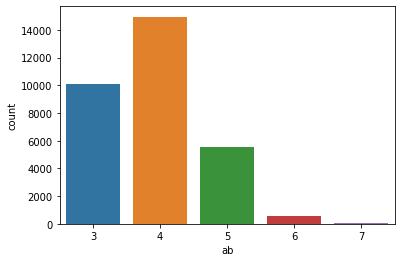

In [78]:
sns.countplot(final_2018_2021['ab'])
plt.show()

In [50]:
final_2018_2021.loc[final_2018_2021['start_member']== False]

,name,day,vs,result_x,bat_order,position,start_member,ab,score,hit,2_hit,3_hit,homerun,tb,rbi,sb,cs,bb,hpp,ibb,so,gdp,sh,sf,avg,obp,slg,ops,pitch,avLI,RE24,WPA,double,vs_team_x,home/away_x,home_ab_x,home_hit_x,away_ab_x,away_hit_x,home/away_avg_x,vs_team_y,home/away_y,home_ab_y,home_hit_y,away_ab_y,away_hit_y,home/away_avg_y,vs_team,result_y,home/away,vs_ab,vs_hit,vs_avg,recent_5days_avg,recent_5games_avg,recent_10games_avg,success_10days,success_10games


### **Multi layer Perceptron in Be the legend**

In [79]:
mlp_data = final_2018_2021.loc[:, ['name', 'start_member', 'vs_team', 'avg', 'slg', 'ops', 'home/away_avg_y', 'vs_ab', 'vs_hit', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg', 'success_10days', 'success_10games', 'result_y']]

In [80]:
mlp_data

,name,start_member,vs_team,avg,slg,ops,home/away_avg_y,vs_ab,vs_hit,vs_avg,recent_5days_avg,recent_5games_avg,recent_10games_avg,success_10days,success_10games,result_y
0,강백호,True,한화,0.667,0.667,1.417,0.000,0,0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,강백호,True,LG,0.286,0.286,0.661,0.667,0,0,0.000,0.666667,0.666667,0.666667,1.000000,1.000000,0
2,강백호,True,LG,0.455,0.455,0.993,0.286,4,0,0.000,0.285714,0.285714,0.285714,0.500000,0.500000,1
3,강백호,True,LG,0.467,0.467,0.996,0.455,8,3,0.375,0.454545,0.454545,0.454545,0.666667,0.666667,1
4,강백호,True,삼성,0.500,0.600,1.145,0.000,0,0,0.000,0.466667,0.466667,0.466667,0.750000,0.750000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11300,강경학,True,SK,0.285,0.398,0.789,0.272,24,9,0.375,0.000000,0.000000,0.142857,0.333333,0.300000,1
11301,강경학,True,LG,0.281,0.393,0.782,0.271,21,9,0.429,0.100000,0.071429,0.166667,0.375000,0.400000,0
11302,강경학,True,NC,0.281,0.390,0.777,0.301,22,4,0.182,0.125000,0.076923,0.120000,0.142857,0.300000,1
11305,강경학,True,KIA,0.284,0.405,0.798,0.270,23,5,0.217,0.400000,0.250000,0.130435,0.500000,0.300000,1


In [81]:
len(mlp_data)

31170

In [58]:
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.preprocessing import minmax_scale
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [82]:
mlp_train, mlp_test = train_test_split(mlp_data, test_size=0.2, random_state=50)

In [83]:
X_train = mlp_train.loc[:, ['avg', 'slg', 'ops', 'home/away_avg_y', 'vs_ab', 'vs_hit', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg', 'success_10days', 'success_10games']]
y_train = mlp_train.loc[:, ['result_y']]

X_test = mlp_test.loc[:, ['avg', 'slg', 'ops', 'home/away_avg_y', 'vs_ab', 'vs_hit', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg', 'success_10days', 'success_10games']]
y_test = mlp_test.loc[:, ['result_y']]

In [84]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [85]:
number_of_train_samples = X_train.shape[0]
width = X_train.shape[1]
X_train = X_train.reshape(number_of_train_samples, width)

In [86]:
number_of_test_samples = X_test.shape[0]
X_test = X_test.reshape(number_of_test_samples, width)

In [87]:
X_train = minmax_scale(X_train, feature_range=(0,1), axis = 0)
X_test = minmax_scale(X_test, feature_range=(0,1), axis = 0)

In [88]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [89]:
model = Sequential()

model.add(Dense(512, input_dim= width, kernel_initializer = 'glorot_uniform', activation = 'relu'))
# model.add(Dropout(0.3))
model.add(Dense(300, kernel_initializer = 'glorot_uniform', activation = 'relu'))
model.add(Dense(256, kernel_initializer = 'glorot_uniform', activation = 'relu'))

model.add(Dense(128, kernel_initializer = 'glorot_uniform', activation = 'relu'))

model.add(Dense(64, kernel_initializer = 'glorot_uniform', activation = 'relu'))

model.add(Dense(32, kernel_initializer = 'glorot_uniform', activation = 'relu'))
model.add(Dense(16, kernel_initializer = 'glorot_uniform', activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [90]:
history = model.fit(X_train, y_train, epochs= 100, batch_size = 32)

Epoch 1/100
780/780 [==============================] - 4s 5ms/step - loss: 0.6163 - accuracy: 0.7109
Epoch 2/100
780/780 [==============================] - 4s 4ms/step - loss: 0.5930 - accuracy: 0.7192
Epoch 3/100
780/780 [==============================] - 4s 5ms/step - loss: 0.5936 - accuracy: 0.7181
Epoch 4/100
780/780 [==============================] - 3s 4ms/step - loss: 0.5954 - accuracy: 0.7155
Epoch 5/100
780/780 [==============================] - 4s 5ms/step - loss: 0.5926 - accuracy: 0.7177
Epoch 6/100
780/780 [==============================] - 3s 4ms/step - loss: 0.5928 - accuracy: 0.7162
Epoch 7/100
780/780 [==============================] - 4s 5ms/step - loss: 0.5929 - accuracy: 0.7152
Epoch 8/100
780/780 [==============================] - 3s 4ms/step - loss: 0.5908 - accuracy: 0.7142
Epoch 9/100
780/780 [==============================] - 3s 4ms/step - loss: 0.5882 - accuracy: 0.7134
Epoch 10/100
780/780 [==============================] - 4s 5ms/step - loss: 0.5793 - accura

In [91]:
loss_and_metrics = model.evaluate(X_test, y_test, batch_size = 32)

195/195 [==============================] - 1s 2ms/step - loss: 0.5463 - accuracy: 0.7422


In [96]:
len(mlp_data[mlp_data['result_y'] ==1]) / len(mlp_data) * 100

71.66827077317934